In [2]:
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import scipy
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix

## Load the data and data preprocessing

Steps that were carried out:

Data preprocessing
- The original data was discrete and hence we standardized the data by normalization.
- This converted the data from discrete to continuous

In [12]:
data = pd.read_csv('data/train.csv',header=None)
data.columns = ["GeneID", 'BinID','H3K27me3','H3K36me3','H3K4me1','H3K4me3','H3K9me3','Gene_Expression']
train_target = data['Gene_Expression']
scaler = preprocessing.StandardScaler().fit((data.iloc[:, 2:-1]))
data = scaler.transform(data.iloc[:, 2:-1])
test_data = pd.read_csv('data/test.csv',header=None)
test_data.columns = ["GeneID", 'BinID','H3K27me3','H3K36me3','H3K4me1','H3K4me3','H3K9me3','Gene_Expression']
test_target = test_data['Gene_Expression']
scaler = preprocessing.StandardScaler().fit((test_data.iloc[:, 2:-1]))
test_data = scaler.transform(test_data.iloc[:, 2:-1])

data = pd.DataFrame(data)
data[5] = train_target
test_data = pd.DataFrame(test_data)
test_data[5] = test_target

print("input matrix dimension:", test_data.shape)

input matrix dimension: (660000, 6)


# Exploratory Data Analysis

array([[<AxesSubplot:xlabel='0', ylabel='0'>,
        <AxesSubplot:xlabel='1', ylabel='0'>,
        <AxesSubplot:xlabel='2', ylabel='0'>,
        <AxesSubplot:xlabel='3', ylabel='0'>,
        <AxesSubplot:xlabel='4', ylabel='0'>],
       [<AxesSubplot:xlabel='0', ylabel='1'>,
        <AxesSubplot:xlabel='1', ylabel='1'>,
        <AxesSubplot:xlabel='2', ylabel='1'>,
        <AxesSubplot:xlabel='3', ylabel='1'>,
        <AxesSubplot:xlabel='4', ylabel='1'>],
       [<AxesSubplot:xlabel='0', ylabel='2'>,
        <AxesSubplot:xlabel='1', ylabel='2'>,
        <AxesSubplot:xlabel='2', ylabel='2'>,
        <AxesSubplot:xlabel='3', ylabel='2'>,
        <AxesSubplot:xlabel='4', ylabel='2'>],
       [<AxesSubplot:xlabel='0', ylabel='3'>,
        <AxesSubplot:xlabel='1', ylabel='3'>,
        <AxesSubplot:xlabel='2', ylabel='3'>,
        <AxesSubplot:xlabel='3', ylabel='3'>,
        <AxesSubplot:xlabel='4', ylabel='3'>],
       [<AxesSubplot:xlabel='0', ylabel='4'>,
        <AxesSubplot:xlabel='1

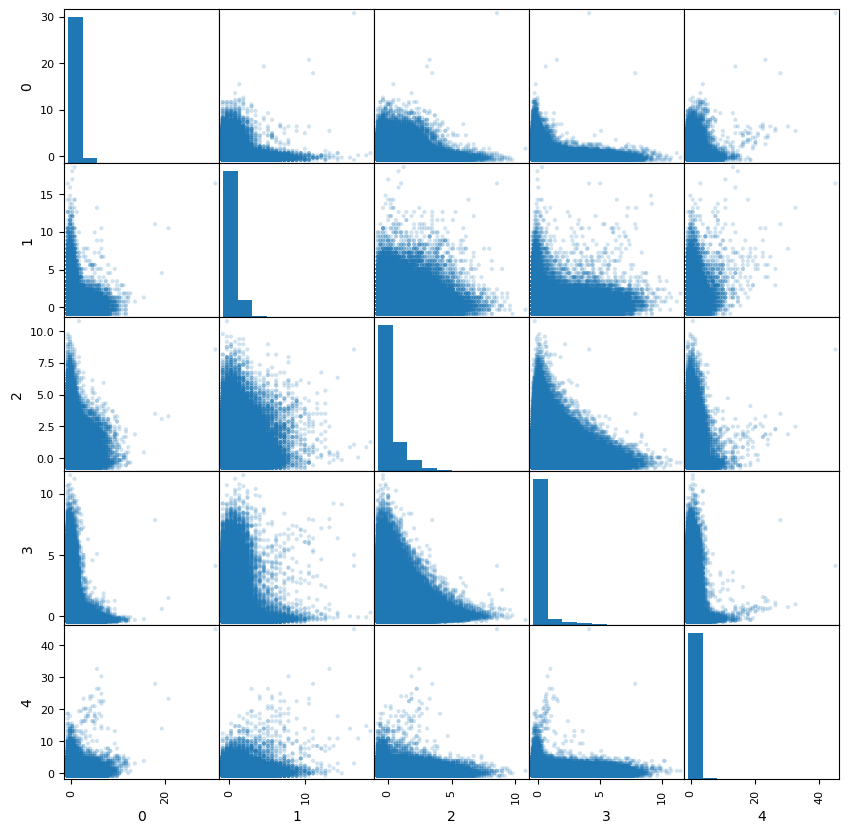

In [38]:
data = pd.read_csv('data/train.csv',header=None)
pd.plotting.scatter_matrix(data.iloc[:,:-1] , alpha=0.2, figsize=(10, 10))

<AxesSubplot:>

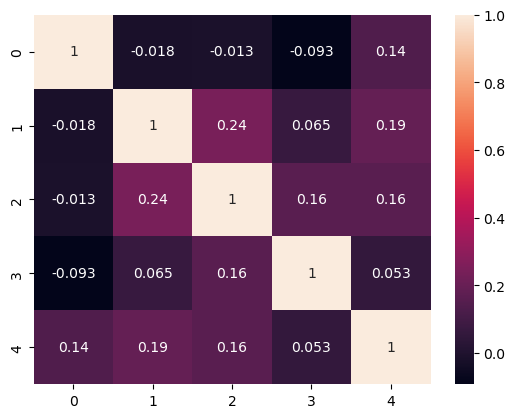

In [37]:
#correlation coefficient matrix between 6 histome markers
data = pd.read_csv('data/train.csv',header=None)
corr_matrix = data.iloc[:,:-1] .corr()
import seaborn as sns
sns.heatmap(corr_matrix, annot=True)

## SVM function

We used the radial basis function kernel in the SVM function
The data does not need to be split into test or train data since we have separate datasets for each

In [13]:
def runSVM(data,test_data):
    X = data.iloc[:,:-1]  # Select the columns for histone modification counts
    y = data.iloc[:, -1]  # Select the column for gene_expression
    X_test = test_data.iloc[:,:-1] 
    y_test = test_data.iloc[:, -1]
    model = SVC(kernel='rbf')
    model.fit(X, y)
    y_pred = model.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test,y_pred).ravel()
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    acc = accuracy_score(y_test, y_pred)
    return roc_auc, tn, fp, fn, tp, acc, fpr, tpr

# Cross Validation

Depends on the input variable folds=k, the function splits the training data into k parts equally.

In [14]:
#data is the original training dataset
from random import randrange
def cross_valid(train_data, folds):
    AUC_Scores = []
    accuracies = []
    train_split = list()
    train_copy = list(train_data.to_numpy())
    fold_size = int(len(train_data)/folds)
    for i in range(folds):
        fold = list()
        while len(fold) < fold_size:
            idx = randrange(len(train_copy))
            fold.append(train_copy.pop(idx))
        train_split.append(pd.DataFrame(fold))
        sub_train = pd.DataFrame(train_split[i])
        
        #grab test data that's not in the subsampled training data
        df_all = train_data.merge(sub_train, on=[0, 1, 2, 3, 4, 5], how='left', indicator=True)
        test_data = df_all.loc[df_all['_merge'] == 'left_only']
        test_data = test_data.drop(columns=['_merge'])
        
        (roc_auc, tn, fp, fn, tp, acc, fpr, tpr) = runSVM(sub_train,test_data)
        AUC_Scores.append(roc_auc)
        accuracies.append(acc)
    return AUC_Scores, accuracies

## Train and run the model

Here, we create and test 100 different models since we have 100 bins for each gene. There are 6601 genes in total.
We also perform 5-fold validation for each model and store its corresponding auc and accuracy 

In [15]:
AUC_Scores = np.zeros(100)
AUC_cross = np.zeros(100)
confusion_matrices = {}
accuracies = np.zeros(100)
accuracies_cross = np.zeros(100)
rates = {}

for i in range(0,100):
    data_train = data.iloc[i::100, :]
    data_test = test_data.iloc[i::100, :]
    (roc_auc, tn, fp, fn, tp,acc,fpr,tpr) = runSVM(data_train,data_test)
    auc_cross, acc_cross = cross_valid(data_train, folds=5)
    AUC_cross[i] = max(auc_cross)
    accuracies_cross[i] = max(acc_cross)
    AUC_Scores[i] = roc_auc
    confusion_matrices[i] = [tn, fp, fn, tp]
    rates[i] = [fpr,tpr]
    accuracies[i] = acc

MAX_AUC = max(AUC_Scores)
MAX_ACC = max(accuracies)
AVG_AUC = np.mean(AUC_Scores)
MAX_ACC_cross = max(accuracies_cross)
MAX_AUC_cross = max(AUC_cross)

# Results and figures

The average AUC for 5-fold validation is 0.6249628292685848
The average accuracy for 5-fold validation is 0.6275302845485167
The precision for SVM is  0.4308873720136519
The Recall for SVM is  0.7054468535166578
The F1 score for SVM is  0.5349977743832103
The maximum accuracy for SVM is  0.7625757575757576
The maximum accuracy for 5-fold validation is  0.6708483946417181
The maximum AUC for 5-fold validation is  0.6797806195973878


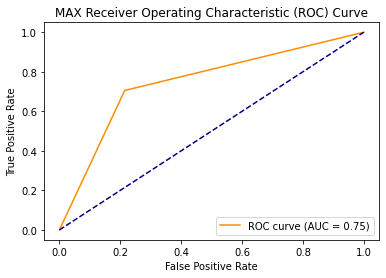

In [18]:
#SVM precision, recall, F1, accuracies
ind = list(AUC_Scores).index(MAX_AUC)
fpr = (confusion_matrices[ind][1])/(confusion_matrices[ind][1]+confusion_matrices[ind][0]) # tpr = tp/tp+fn
tpr = (confusion_matrices[ind][3])/(confusion_matrices[ind][3]+confusion_matrices[ind][2]) # fpr = fp/fp+tn
precision = (confusion_matrices[ind][1])/((confusion_matrices[ind][1])+confusion_matrices[ind][3]) # precision = tp/tp+fp
recall = tpr
f1 = 2*precision*recall/(precision+recall)
print("The average AUC for 5-fold validation is",np.mean(AUC_cross))
print("The average accuracy for 5-fold validation is",np.mean(accuracies_cross))
print("The precision for SVM is ",precision)
print("The Recall for SVM is ",recall)
print("The F1 score for SVM is ",f1)
print("The maximum accuracy for SVM is ", MAX_ACC)
print("The maximum accuracy for 5-fold validation is ", MAX_ACC_cross)
print("The maximum AUC for 5-fold validation is ", MAX_AUC_cross)

fpr = [0,fpr,1]
tpr = [0,tpr,1]
fig, ax = plt.subplots()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (AUC = %0.2f)' % MAX_AUC)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('MAX Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.savefig('SVM_ROC.png',transparent=True,dpi=300,bbox_inches='tight')
plt.show()

# Logistic Regression Model

The logistic Regression model is implemented from scratch using gradient descent approach to minimize the cost function.

In [19]:
#Reload the data to make sure all the variables are reset
data = pd.read_csv('data/train.csv',header=None)
data.columns = ["GeneID", 'BinID','H3K27me3','H3K36me3','H3K4me1','H3K4me3','H3K9me3','Gene_Expression']
train_target = data['Gene_Expression']
scaler = preprocessing.StandardScaler().fit((data.iloc[:, 2:-1]))
data = scaler.transform(data.iloc[:, 2:-1])
test_data = pd.read_csv('data/test.csv',header=None)
test_data.columns = ["GeneID", 'BinID','H3K27me3','H3K36me3','H3K4me1','H3K4me3','H3K9me3','Gene_Expression']
test_target = test_data['Gene_Expression']
scaler = preprocessing.StandardScaler().fit((test_data.iloc[:, 2:-1]))
test_data = scaler.transform(test_data.iloc[:, 2:-1])

data = pd.DataFrame(data)
data[5] = train_target
test_data = pd.DataFrame(test_data)
test_data[5] = test_target

# Initialize parameters
theta = np.random.rand(5) # weights
alpha = 0.01 # learning rate
num_iters = 1000 # number of iterations

# Define the sigmoid function
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Define the cost function
def cost_function(X, y, theta):
    m = len(y)
    h = sigmoid(np.dot(X, theta))
    J = (-1/m) * np.sum(y*np.log(h) + (1-y)*np.log(1-h))
    return J

# Define the gradient descent algorithm
def gradient_descent(X, y, theta, alpha, num_iters):
    m = len(y)
    J_history = np.zeros(num_iters)
    
    for i in range(num_iters):
        h = sigmoid(np.dot(X, theta))
        theta = theta - (alpha/m) * np.dot(X.T, (h-y))
        J_history[i] = cost_function(X, y, theta)
    
    return theta, J_history


# Cross Validation

Depends on the input variable folds=k, the function splits the training data into k parts equally.

In [20]:
#data is the original training dataset
#Takes 5 mins to run 10-fold
from random import randrange
def cross_valid(train_data, theta, alpha, num_iters, folds):
    AUC_Scores = []
    accuracies = []
    train_split = list()
    train_copy = list(train_data.to_numpy())
    fold_size = int(len(train_data)/folds)
    for i in range(folds):
        fold = list()
        #print(f"Number of fold: {i}")
        while len(fold) < fold_size:
            idx = randrange(len(train_copy))
            fold.append(train_copy.pop(idx))
        train_split.append(pd.DataFrame(fold))
        sub_train = pd.DataFrame(train_split[i])
        #grab test data that's not in the subsampled training data
        df_all = train_data.merge(sub_train, on=[0, 1, 2, 3, 4, 5], how='left', indicator=True)
        test_data = df_all.loc[df_all['_merge'] == 'left_only']
        test_data = test_data.drop(columns=['_merge'])
    
        X = sub_train.iloc[:,:-1] # Select the columns for histone modification counts
        y = sub_train.iloc[:, -1]  # Select the binary label for gene expression
    
        theta, J_history = gradient_descent(X, y, theta, alpha, num_iters)

    return theta, J_history, test_data


# Train and run the model

In [21]:
accuracies = []
accuracies_cross = []
AUC_Scores = []
AUC_Scores_cross = []
confusion_matrices = {}
confusion_matrices_cross = {}
theta = np.random.rand(5) # weights
alpha = 0.01 # learning rate
num_iters = 1000 # number of iterations
folds = 5
for i in range(0,100):
    data_train = data.iloc[i::100, :]
    data_test = test_data.iloc[i::100, :]
    X = data_train.iloc[:,:-1] # Select the columns for histone modification counts
    y = data_train.iloc[:, -1]  # Select the binary label for gene expression
    X_test = data_test.iloc[:,:-1] 
    y_test = data_test.iloc[:, -1]
    
    cross_theta, cross_J_history, cross_data_test = cross_valid(data_train, theta, alpha, num_iters, folds)
    cross_X_test = cross_data_test.iloc[:,:-1] 
    cross_y_test = cross_data_test.iloc[:, -1]
    # Train the model
    theta, J_history = gradient_descent(X, y, theta, alpha, num_iters)
    
    
    # Predict the labels
    probabilities = sigmoid(np.dot(X_test, theta))
    labels = (probabilities > 0.5).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test,labels).ravel()
    confusion_matrices[i] = [tn, fp, fn, tp]
    fpr, tpr, thresholds = roc_curve(y_test, labels)
    AUC_Scores.append(auc(fpr, tpr))
    accuracies.append((np.mean(labels == y_test)))
    
    # Predict the labels for cross validation training data
    cross_probabilities = sigmoid(np.dot(cross_X_test, theta))
    cross_labels = (cross_probabilities > 0.5).astype(int)
    cross_tn, cross_fp, cross_fn, cross_tp = confusion_matrix(cross_y_test,cross_labels).ravel()
    confusion_matrices_cross[i] = [cross_tn, cross_fp, cross_fn, cross_tp]
    fpr_c, tpr_c, thresholds_c = roc_curve(cross_y_test, cross_labels)
    AUC_Scores_cross.append(auc(fpr_c, tpr_c))
    accuracies_cross.append((np.mean(cross_labels == cross_y_test)))
                                  
MAX_Acc = max(accuracies)
AVG_Acc = np.mean(accuracies)
MAX_AUC = max(AUC_Scores)

MAX_Acc_cross = max(accuracies_cross)
AVG_Acc_cross = np.mean(accuracies_cross)
MAX_AUC_cross = max(AUC_Scores_cross)
AVG_AUC_cross = np.mean(AUC_Scores_cross)

# Results and figures

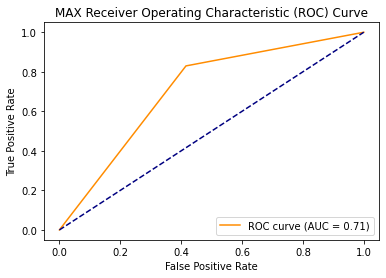

The average AUC for 5-fold validation is 0.625750606068323
The average accuracy for 5-fold validation is 0.6239207839719075
The precision for Logistic Regression is  0.5551460164445705
The Recall for Logistic Regression is  0.8297197250132206
The F1 score for Logistic Regression is  0.665213365191203
The maximum accuracy for Logistic Regression is  0.7119696969696969
The maximum accuracy for 5-fold validation is  0.6239207839719075
The maximum AUC for 5-fold validation is  0.66561681647675


In [22]:
ind = list(AUC_Scores).index(MAX_AUC)
fpr = (confusion_matrices[ind][1])/(confusion_matrices[ind][1]+confusion_matrices[ind][0]) # tpr = tp/tp+fn
tpr = (confusion_matrices[ind][3])/(confusion_matrices[ind][3]+confusion_matrices[ind][2]) # fpr = fp/fp+tn
precision = (confusion_matrices[ind][1])/((confusion_matrices[ind][1])+confusion_matrices[ind][3]) # precision = tp/tp+fp
recall = tpr
f1 = 2*precision*recall/(precision+recall)

fpr = [0,fpr,1]
tpr = [0,tpr,1]
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (AUC = %0.2f)' % MAX_AUC)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('MAX Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
#Logistic Regression precision, recall, F1, accuracies
print("The average AUC for 5-fold validation is", AVG_AUC_cross)
print("The average accuracy for 5-fold validation is", AVG_Acc_cross)
print("The precision for Logistic Regression is ", precision)
print("The Recall for Logistic Regression is ", recall)
print("The F1 score for Logistic Regression is ", f1)
print("The maximum accuracy for Logistic Regression is ", MAX_Acc)
print("The maximum accuracy for 5-fold validation is ", AVG_Acc_cross)
print("The maximum AUC for 5-fold validation is ", MAX_AUC_cross)

# Decision Tree Model

In [6]:
from collections import Counter

data = pd.read_csv('data/train.csv',header=None)
data.columns = ["GeneID", 'BinID','H3K27me3','H3K36me3','H3K4me1','H3K4me3','H3K9me3','Gene_Expression']
train_target = data['Gene_Expression']
scaler = preprocessing.StandardScaler().fit((data.iloc[:, 2:-1]))
data = scaler.transform(data.iloc[:, 2:-1])
test_data = pd.read_csv('data/test.csv',header=None)
test_data.columns = ["GeneID", 'BinID','H3K27me3','H3K36me3','H3K4me1','H3K4me3','H3K9me3','Gene_Expression']
test_target = test_data['Gene_Expression']
scaler = preprocessing.StandardScaler().fit((test_data.iloc[:, 2:-1]))
test_data = scaler.transform(test_data.iloc[:, 2:-1])

data = pd.DataFrame(data)
data[5] = train_target
test_data = pd.DataFrame(test_data)
test_data[5] = test_target

class Node: 
    """
    Class for creating the nodes for a decision tree 
    """
    def __init__(
        self, 
        Y: list,
        X: pd.DataFrame,
        min_samples_split=None,
        max_depth=None,
        depth=None,
        node_type=None,
        rule=None
    ):
        # Saving the data to the node 
        self.Y = Y 
        self.X = X

        # Saving the hyper parameters
        self.min_samples_split = min_samples_split if min_samples_split else 20
        self.max_depth = max_depth if max_depth else 5

        # Default current depth of node 
        self.depth = depth if depth else 0

        # Extracting all the features
        self.features = list(self.X.columns)

        # Type of node 
        self.node_type = node_type if node_type else 'root'

        # Rule for spliting 
        self.rule = rule if rule else ""

        # Calculating the counts of Y in the node 
        self.counts = Counter(Y)

        # Getting the GINI impurity based on the Y distribution
        self.gini_impurity = self.get_GINI()

        # Sorting the counts and saving the final prediction of the node 
        counts_sorted = list(sorted(self.counts.items(), key=lambda item: item[1]))

        # Getting the last item
        yhat = None
        if len(counts_sorted) > 0:
            yhat = counts_sorted[-1][0]

        # Saving to object attribute. This node will predict the class with the most frequent class
        self.yhat = yhat 

        # Saving the number of observations in the node 
        self.n = len(Y)

        # Initiating the left and right nodes as empty nodes
        self.left = None 
        self.right = None 

        # Default values for splits
        self.best_feature = None 
        self.best_value = None 

    @staticmethod
    def GINI_impurity(y1_count: int, y2_count: int) -> float:
        """
        Given the observations of a binary class calculate the GINI impurity
        """
        # Ensuring the correct types
        if y1_count is None:
            y1_count = 0

        if y2_count is None:
            y2_count = 0

        # Getting the total observations
        n_tot = y1_count + y2_count
        
        # If n is 0 then we return the lowest possible gini impurity
        if n_tot == 0:
            return 0.0

        # Getting the probability to see each of the classes
        p1 = y1_count / n_tot
        p2 = y2_count / n_tot
        
        # Calculating GINI 
        gini = 1 - (p1 ** 2 + p2 ** 2)
        
        # Returning the gini impurity
        return gini

    @staticmethod
    def ma(x: np.array, window: int) -> np.array:
        """
        Calculates the moving average of the given list. 
        """
        return np.convolve(x, np.ones(window), 'valid') / window

    def get_GINI(self):
        """
        Function to calculate the GINI impurity of a node 
        """
        # Getting the 0 and 1 counts
        y1_count, y2_count = self.counts.get(0, 0), self.counts.get(1, 0)

        # Getting the GINI impurity
        return self.GINI_impurity(y1_count, y2_count)

    def best_split(self) -> tuple:
        """
        Given the X features and Y targets calculates the best split 
        for a decision tree
        """
        # Creating a dataset for spliting
        df = self.X.copy()
        df['Y'] = self.Y

        # Getting the GINI impurity for the base input 
        GINI_base = self.get_GINI()

        # Finding which split yields the best GINI gain 
        max_gain = 0

        # Default best feature and split
        best_feature = None
        best_value = None

        for feature in self.features:
            # Droping missing values
            Xdf = df.dropna().sort_values(feature)

            # Sorting the values and getting the rolling average
            xmeans = self.ma(Xdf[feature].unique(), 2)

            for value in xmeans:
                # Spliting the dataset 
                left_counts = Counter(Xdf[Xdf[feature]<value]['Y'])
                right_counts = Counter(Xdf[Xdf[feature]>=value]['Y'])

                # Getting the Y distribution from the dicts
                y0_left, y1_left, y0_right, y1_right = left_counts.get(0, 0), left_counts.get(1, 0), right_counts.get(0, 0), right_counts.get(1, 0)

                # Getting the left and right gini impurities
                gini_left = self.GINI_impurity(y0_left, y1_left)
                gini_right = self.GINI_impurity(y0_right, y1_right)

                # Getting the obs count from the left and the right data splits
                n_left = y0_left + y1_left
                n_right = y0_right + y1_right

                # Calculating the weights for each of the nodes
                w_left = n_left / (n_left + n_right)
                w_right = n_right / (n_left + n_right)

                # Calculating the weighted GINI impurity
                wGINI = w_left * gini_left + w_right * gini_right

                # Calculating the GINI gain 
                GINIgain = GINI_base - wGINI

                # Checking if this is the best split so far 
                if GINIgain > max_gain:
                    best_feature = feature
                    best_value = value 

                    # Setting the best gain to the current one 
                    max_gain = GINIgain

        return (best_feature, best_value)

    def grow_tree(self):
        """
        Recursive method to create the decision tree
        """
        # Making a df from the data 
        df = self.X.copy()
        df['Y'] = self.Y

        # If there is GINI to be gained, we split further 
        if (self.depth < self.max_depth) and (self.n >= self.min_samples_split):

            # Getting the best split 
            best_feature, best_value = self.best_split()

            if best_feature is not None:
                # Saving the best split to the current node 
                self.best_feature = best_feature
                self.best_value = best_value

                # Getting the left and right nodes
                left_df, right_df = df[df[best_feature]<=best_value].copy(), df[df[best_feature]>best_value].copy()

                # Creating the left and right nodes
                left = Node(
                    left_df['Y'].values.tolist(), 
                    left_df[self.features], 
                    depth=self.depth + 1, 
                    max_depth=self.max_depth, 
                    min_samples_split=self.min_samples_split, 
                    node_type='left_node',
                    rule=f"{best_feature} <= {round(best_value, 3)}"
                    )

                self.left = left 
                self.left.grow_tree()

                right = Node(
                    right_df['Y'].values.tolist(), 
                    right_df[self.features], 
                    depth=self.depth + 1, 
                    max_depth=self.max_depth, 
                    min_samples_split=self.min_samples_split,
                    node_type='right_node',
                    rule=f"{best_feature} > {round(best_value, 3)}"
                    )

                self.right = right
                self.right.grow_tree()

    def predict(self, X:pd.DataFrame):
        """
        Batch prediction method
        """
        predictions = []

        for _, x in X.iterrows():
            values = {}
            for feature in self.features:
                values.update({feature: x[feature]})
        
            predictions.append(self.predict_obs(values))
        
        return predictions

    def predict_obs(self, values: dict) -> int:
        """
        Method to predict the class given a set of features
        """
        cur_node = self
        #print('values',values)
        while cur_node.depth < cur_node.max_depth:
     
            # Traversing the nodes all the way to the bottom
            best_feature = cur_node.best_feature
       
            best_value = cur_node.best_value
          
            #if best_feature != None and best_value != None:

            if cur_node.n < cur_node.min_samples_split:
                break 

            if (values.get(best_feature) < best_value):
                if self.left is not None:
                    cur_node = cur_node.left
            else:
                if self.right is not None:
                    cur_node = cur_node.right

        return cur_node.yhat
    

# Cross Validation

In [8]:
#data is the original training dataset
from random import randrange
def cross_valid(train_data, folds):
    acc_Scores = []
    auc_Scores = []
    confusion_mat={}
    y_preds = []
    train_split = list()
    train_copy = list(train_data.to_numpy())
    fold_size = int(len(train_data)/folds)
    for i in range(folds):
        fold = list()
        while len(fold) < fold_size:
            idx = randrange(len(train_copy))
            fold.append(train_copy.pop(idx))
        train_split.append(pd.DataFrame(fold))
        sub_train = pd.DataFrame(train_split[i])
        
        y_test = sub_train.iloc[:, -1]
        y_pred = root.predict(sub_train.iloc[:,:-1])
        tn, fp, fn, tp = confusion_matrix(y_test,y_pred).ravel()
        confusion_mat[i]=[tn,fp,fn,tp]
        fpr, tpr, thresholds = roc_curve(y_test, y_pred)
        roc_auc = auc(fpr, tpr)
        auc_Scores.append(roc_auc)
        acc_Scores.append(accuracy_score(y_test,y_pred))

    return auc_Scores, acc_Scores

# Train and run the model

In [10]:
data_train = data.iloc[0::100, :]
data_test = test_data.iloc[0::100, :]
acc_Scores = []
auc_Scores = []
confusion_mat={}
for i in range(0,100):
    data_train = data.iloc[i::100, :]
    data_test = test_data.iloc[i::100, :]
    X = data_train.iloc[:,:-1]  # Select the columns for histone modification counts
    y = data_train.iloc[:, -1]
    X_test = data_test.iloc[:,:-1] 
    y_test = data_test.iloc[:, -1]
    features = list(X.columns)
    hp = {'max_depth': 3,'min_samples_split': 50}
    root = Node(y, X, **hp)
    root.grow_tree()
    y_pred=root.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test,y_pred).ravel()
    confusion_mat[i]=[tn,fp,fn,tp]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    auc_Scores.append(roc_auc)
    acc = accuracy_score(y_test, y_pred)
    #return roc_auc, tn, fp, fn, tp, acc, fpr, tpr
    acc_Scores.append(accuracy_score(y_test,y_pred))
    
    cross_auc, cross_acc = cross_valid(data_train, folds=5)
    
    
MAX_AUC = max(auc_Scores)
AVG_AUC = np.mean(auc_Scores)
MAX_Acc_cross = max(cross_acc)
AVG_Acc_cross = np.mean(cross_acc)
MAX_AUC_cross = max(cross_auc)
AVG_AUC_cross = np.mean(cross_auc)

# Results and figures

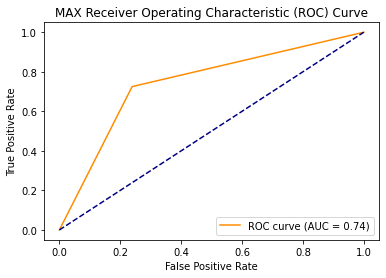

The average AUC for 5-fold validation is 0.5994522178736825
The average accuracy for 5-fold validation is 0.6103030303030302
The precision for Decision Tree is  0.45072115384615385
The Recall for Decision Tree is  0.7250132205182444
The F1 score for Decision Tree is  0.5558718064738996
The maximum accuracy for Decision Tree is  0.7507575757575757
The maximum accuracy for 5-fold validation is  0.6333333333333333
The maximum AUC for 5-fold validation is  0.6211914452819213


In [11]:
ind = list(auc_Scores).index(MAX_AUC)
fpr = (confusion_mat[ind][1])/(confusion_mat[ind][1]+confusion_mat[ind][0]) # fpr = fp/fp+tn
tpr = (confusion_mat[ind][3])/(confusion_mat[ind][3]+confusion_mat[ind][2]) # tpr = tp/tp+fn
precision = (confusion_mat[ind][1])/((confusion_mat[ind][1])+confusion_mat[ind][3]) # precision = tp/tp+fp
recall = tpr
f1 = 2*precision*recall/(precision+recall)
fpr = [0,fpr,1]
tpr = [0,tpr,1]
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (AUC = %0.2f)' % MAX_AUC)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('MAX Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.savefig('SVM_ROC.png',transparent=True,dpi=300,bbox_inches='tight')
plt.show()
#Decision Tree precision, recall, F1, accuracies
print("The average AUC for 5-fold validation is", AVG_AUC_cross)
print("The average accuracy for 5-fold validation is", AVG_Acc_cross)
print("The precision for Decision Tree is ",precision)
print("The Recall for Decision Tree is ",recall)
print("The F1 score for Decision Tree is ",f1)
print("The maximum accuracy for Decision Tree is ", max(acc_Scores))
print("The maximum accuracy for 5-fold validation is ", MAX_Acc_cross)
print("The maximum AUC for 5-fold validation is ", MAX_AUC_cross)

# Additional visualizations generated for final report

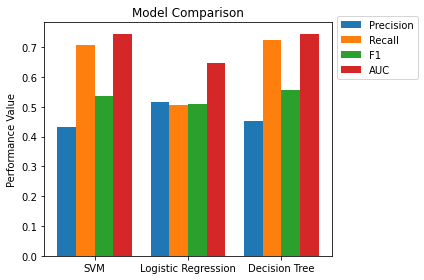

In [115]:
labels = ["SVM", "Logistic Regression", "Decision Tree"]
x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

precisions=[0.4308873720136519, 0.5154430379746835, 0.45072115384615385]
recalls=[0.7054468535166578, 0.506081438392385, 0.7250132205182444]
f1s=[0.5349977743832103, 0.5107193417337835, 0.5558718064738996]
aucs=[0.7454819742206351, 0.6449498294106755, 0.7430544972839681]
fig, ax = plt.subplots()
rects1 = ax.bar(x - 1.5*width, precisions, width, label='Precision')
rects2 = ax.bar(x - .5*width, recalls, width, label='Recall')
rects3 = ax.bar(x + .5*width, f1s, width, label='F1')
rects4 = ax.bar(x + 1.5*width, aucs, width, label='AUC')

plt.ylabel('Performance Value')
plt.title('Model Comparison')
plt.xticks(x, labels)
plt.legend(bbox_to_anchor=(1, 1.05))


fig.tight_layout()
plt.grid(False)
plt.savefig('ModelPerformance.png',transparent=True,dpi=300,bbox_inches='tight')
plt.show()

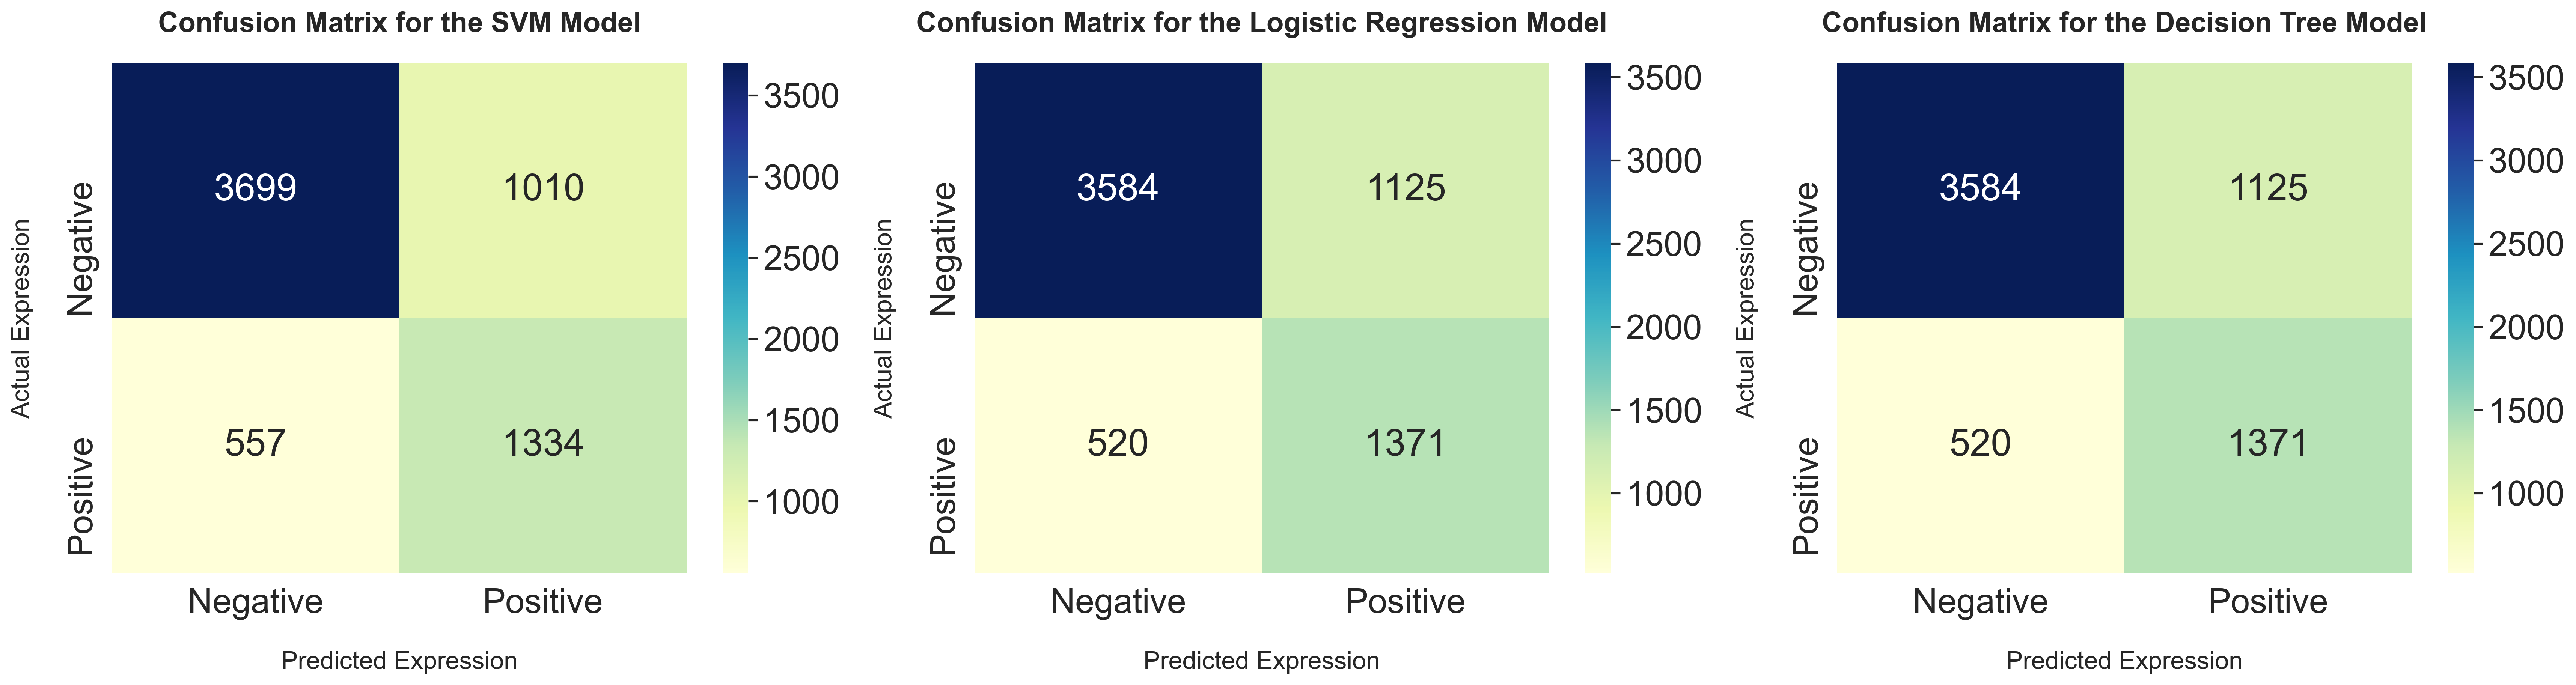

In [118]:
# Scale up the size of all text
sns.set(font_scale = 2)
confus_mat = np.array([3584, 1125, 520, 1371]).reshape((2, -1))
confus_mat_svm = np.array([3699, 1010, 557, 1334]).reshape((2, -1))
confus_mat_lr = np.array([3691, 1018, 934, 957]).reshape((2, -1))
fig = plt.figure(figsize=(28, 6), dpi=300)
####SVM
plt.subplot(1, 3, 1)
ax1 = sns.heatmap(confus_mat_svm, annot=True, fmt='d', cmap="YlGnBu")
ax1.set_xlabel("Predicted Expression", fontsize=16, labelpad=20)
ax1.xaxis.set_ticklabels(['Negative', 'Positive'])

# set y-axis label and ticks
ax1.set_ylabel("Actual Expression", fontsize=16, labelpad=20)
ax1.yaxis.set_ticklabels(['Negative', 'Positive'])

# set plot title
ax1.set_title("Confusion Matrix for the SVM Model", fontsize=18, pad=20, fontweight='bold')

#####Logistic
plt.subplot(1, 3, 2)
ax2 = sns.heatmap(confus_mat, annot=True, fmt='d', cmap="YlGnBu")
ax2.set_xlabel("Predicted Expression", fontsize=16, labelpad=20)
ax2.xaxis.set_ticklabels(['Negative', 'Positive'])

# set y-axis label and ticks
ax2.set_ylabel("Actual Expression", fontsize=16, labelpad=20)
ax2.yaxis.set_ticklabels(['Negative', 'Positive'])

# set plot title
ax2.set_title("Confusion Matrix for the Logistic Regression Model", fontsize=18, pad=20, fontweight='bold')

#####SVM
plt.subplot(1, 3, 3)
ax3 = sns.heatmap(confus_mat, annot=True, fmt='d', cmap="YlGnBu")
ax3.set_xlabel("Predicted Expression", fontsize=16, labelpad=20)
ax3.xaxis.set_ticklabels(['Negative', 'Positive'])

# set y-axis label and ticks
ax3.set_ylabel("Actual Expression", fontsize=16, labelpad=20)
ax3.yaxis.set_ticklabels(['Negative', 'Positive'])

# set plot title
ax3.set_title("Confusion Matrix for the Decision Tree Model", fontsize=18, pad=20, fontweight='bold')
plt.savefig('conf_mtxs.png',transparent=True,dpi=300,bbox_inches='tight')

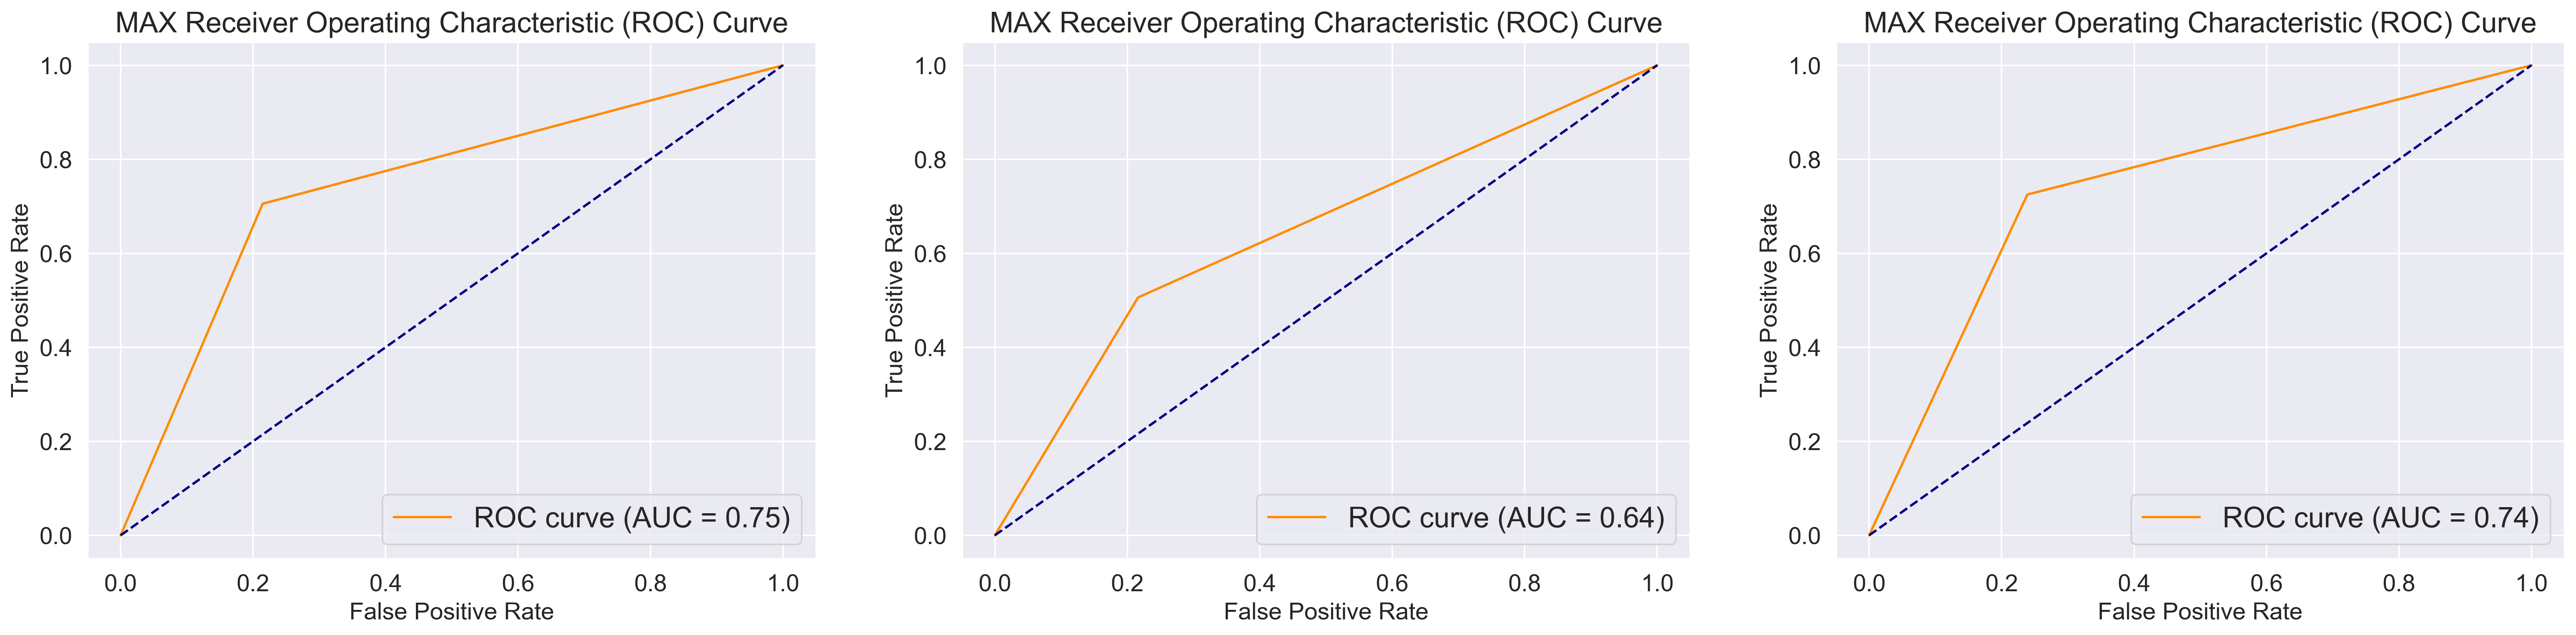

In [119]:
# Scale up the size of all text
fig = plt.figure(figsize=(28, 6), dpi=300)
####SVM
plt.subplot(1, 3, 1)
plt.plot([0, 0.21448290507538756, 1], [0, 0.7054468535166578, 1], color='darkorange', label='ROC curve (AUC = %0.2f)' % 0.75)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate', fontsize=15)
plt.ylabel('True Positive Rate', fontsize=15)
plt.title('MAX Receiver Operating Characteristic (ROC) Curve', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc="lower right", fontsize=18)

#####Logistic
plt.subplot(1, 3, 2)
plt.plot([0, 0.21618177957103418, 1], [0, 0.506081438392385, 1], color='darkorange', label='ROC curve (AUC = %0.2f)' % 0.64)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate', fontsize=15)
plt.ylabel('True Positive Rate', fontsize=15)
plt.title('MAX Receiver Operating Characteristic (ROC) Curve', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc="lower right", fontsize=18)
#####DT
plt.subplot(1, 3, 3)
plt.plot([0, 0.2389042259503079, 1], [0, 0.7250132205182444, 1], color='darkorange', label='ROC curve (AUC = %0.2f)' % 0.74)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate', fontsize=15)
plt.ylabel('True Positive Rate', fontsize=15)
plt.title('MAX Receiver Operating Characteristic (ROC) Curve', fontsize=18)
plt.legend(loc="lower right", fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig('ROCs_all.png',transparent=True,dpi=300,bbox_inches='tight')